In [1]:
import pandas as pd
import support_functions as sf
import seaborn as sns


from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, round
import findspark
import matplotlib.pyplot as plt


sf.set_environ()
pd.set_option('display.max_columns', None,'display.max_rows', None)
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [2]:
# Bureau.csv
spk_abt_00=spark.read.csv(r"C:\Users\vinic\OneDrive\BigData & Analytics\hacktown\pod-academy-analise-de-credito-para-fintech\bureau.csv",header=True)
spk_abt_00.createOrReplaceTempView('spk_abt_00')
print((spk_abt_00.count(), len(spk_abt_00.columns)))


(1716428, 17)


In [3]:
pd_abt_00=spk_abt_00.toPandas()
metadata_abt_00=sf.generate_metadata(pd_abt_00)
print(metadata_abt_00)

             nome_variavel    tipo  qt_nulos  percent_nulos  cardinalidade  \
0              AMT_ANNUITY  object   1226791          71.47          40321   
1   AMT_CREDIT_MAX_OVERDUE  object   1124488          65.51          68251   
2        DAYS_ENDDATE_FACT  object    633653          36.92           2917   
3     AMT_CREDIT_SUM_LIMIT  object    591780          34.48          51726   
4      AMT_CREDIT_SUM_DEBT  object    257669          15.01         226537   
5      DAYS_CREDIT_ENDDATE  object    105553           6.15          14096   
6            CREDIT_ACTIVE  object         0           0.00              4   
7          CREDIT_CURRENCY  object         0           0.00              4   
8              DAYS_CREDIT  object         0           0.00           2923   
9       CREDIT_DAY_OVERDUE  object         0           0.00            942   
10            SK_ID_BUREAU  object         0           0.00        1716428   
11      CNT_CREDIT_PROLONG  object         0           0.00     

In [6]:
#Bureau_balance
spk_abt_01=spark.read.csv(r"C:\Users\vinic\OneDrive\BigData & Analytics\hacktown\pod-academy-analise-de-credito-para-fintech\bureau_balance.csv",header=True)
spk_abt_01.createOrReplaceTempView('spk_abt_01')
print((spk_abt_01.count(), len(spk_abt_01.columns)))

(27299925, 3)


In [9]:
pd_abt_01=pd.read_csv(r"C:\Users\vinic\OneDrive\BigData & Analytics\hacktown\pod-academy-analise-de-credito-para-fintech\bureau_balance.csv")
metadata_abt_01=sf.generate_metadata(pd_abt_01)
print(metadata_abt_01)

    nome_variavel    tipo  qt_nulos  percent_nulos  cardinalidade  \
0    SK_ID_BUREAU   int64         0            0.0         817395   
1  MONTHS_BALANCE   int64         0            0.0             97   
2          STATUS  object         0            0.0              8   

   percet_cardinalidade  
0                  2.99  
1                  0.00  
2                  0.00  


In [19]:
# Média de atraso em dias separados por bucket
spk_abt_02 = spark.sql("""select 
                        AVG(CASE WHEN CREDIT_DAY_OVERDUE<=180 then CREDIT_DAY_OVERDUE else NULL end) as MEAN_DAY_OVERDUE_0_180,
                        AVG(CASE WHEN CREDIT_DAY_OVERDUE>180 and CREDIT_DAY_OVERDUE<=360 then CREDIT_DAY_OVERDUE else NULL end) as MEAN_DAY_OVERDUE_180_360,
                        AVG(CASE WHEN CREDIT_DAY_OVERDUE>360 and CREDIT_DAY_OVERDUE<=720 then CREDIT_DAY_OVERDUE else NULL end) as MEAN_DAY_OVERDUE_360_720,
                        AVG(CASE WHEN CREDIT_DAY_OVERDUE>720  then CREDIT_DAY_OVERDUE else NULL end) as MEAN_DAY_OVERDUE_720_plus
                        
                        from spk_abt_00""")
spk_abt_02.createOrReplaceTempView('spk_abt_02')

In [20]:
spk_abt_02.show()

+----------------------+------------------------+------------------------+-------------------------+
|MEAN_DAY_OVERDUE_0_180|MEAN_DAY_OVERDUE_180_360|MEAN_DAY_OVERDUE_360_720|MEAN_DAY_OVERDUE_720_plus|
+----------------------+------------------------+------------------------+-------------------------+
|   0.07148145211874188|      255.34848484848484|       571.1444444444444|       1724.6822289156626|
+----------------------+------------------------+------------------------+-------------------------+



In [21]:
pd_abt_02=spk_abt_02.toPandas()


(array([0, 1, 2, 3]),
 [Text(0, 0, 'MEAN_DAY_OVERDUE_0_180'),
  Text(1, 0, 'MEAN_DAY_OVERDUE_180_360'),
  Text(2, 0, 'MEAN_DAY_OVERDUE_360_720'),
  Text(3, 0, 'MEAN_DAY_OVERDUE_720_plus')])

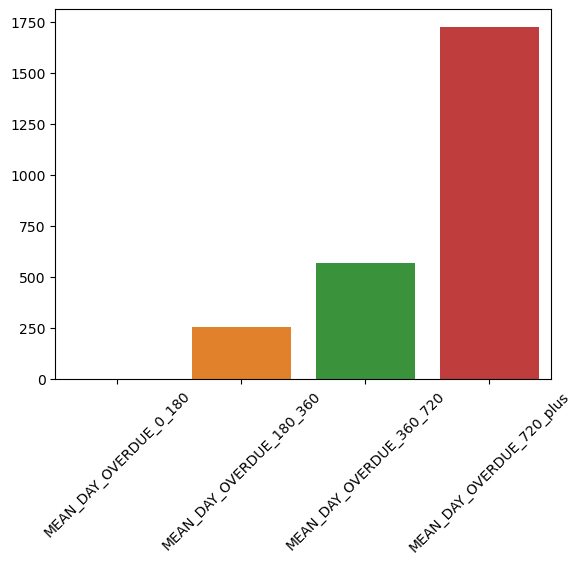

In [41]:
sns.barplot(data=pd_abt_02)
plt.xticks(rotation=45)

In [39]:
#Numero de clientes distintos de acordo com os o status do crédito 
spk_abt_03=spark.sql("""
SELECT CREDIT_ACTIVE,
COUNT(DISTINCT(SK_ID_CURR)) as QTD_UNIQUE_CLIENTS,
COUNT(SK_ID_CURR) as QTD_CREDITS
from spk_abt_00
group by CREDIT_ACTIVE  
""")
spk_abt_03.createOrReplaceTempView('spk_abt_03')
spk_abt_03.show()

+-------------+------------------+-----------+
|CREDIT_ACTIVE|QTD_UNIQUE_CLIENTS|QTD_CREDITS|
+-------------+------------------+-----------+
|     Bad debt|                21|         21|
|         Sold|              6021|       6527|
|       Active|            251815|     630607|
|       Closed|            267925|    1079273|
+-------------+------------------+-----------+



In [35]:
#Numero de clientes distintos de acordo com os o status do crédito 
spk_abt_04=spark.sql("""
SELECT SK_ID_CURR,
SUM(CASE WHEN CREDIT_ACTIVE = 'Active' THEN 1 ELSE 0 END) as QT_CREDIT_ACTIVE,
SUM(CASE WHEN CREDIT_ACTIVE = 'Sold' THEN 1 ELSE 0 END) as QT_CREDIT_SOLD,
SUM(CASE WHEN CREDIT_ACTIVE = 'Bad debt' THEN 1 ELSE 0 END) as QT_CREDIT_BAD_DEBT,
SUM(CASE WHEN CREDIT_ACTIVE = 'Closed' THEN 1 ELSE 0 END) as QT_CREDIT_CLOSED
from spk_abt_00
group by SK_ID_CURR  
""")
spk_abt_04.createOrReplaceTempView('spk_abt_03')
spk_abt_04.show()

+----------+----------------+--------------+------------------+----------------+
|SK_ID_CURR|QT_CREDIT_ACTIVE|QT_CREDIT_SOLD|QT_CREDIT_BAD_DEBT|QT_CREDIT_CLOSED|
+----------+----------------+--------------+------------------+----------------+
|    370925|               0|             0|                 0|               1|
|    233505|               4|             0|                 0|               0|
|    146433|               1|             0|                 0|               5|
|    297765|               3|             0|                 0|               0|
|    106090|               1|             0|                 0|               0|
|    291034|               1|             0|                 0|               3|
|    362212|               1|             0|                 0|               3|
|    424856|               1|             0|                 0|               7|
|    142039|               0|             0|                 0|               1|
|    416451|               1

In [40]:
#Distribuição do tipo de Crédito
spk_abt_05=spark.sql("""
SELECT CREDIT_TYPE, 
COUNT(DISTINCT(SK_ID_CURR)) as QTD_UNIQUE_CLIENTS,
COUNT(SK_ID_CURR) as QTD_CREDITS
from spk_abt_00
group by CREDIT_TYPE
""")
spk_abt_05.createOrReplaceTempView('spk_abt_05')
spk_abt_05.show()

+--------------------+------------------+-----------+
|         CREDIT_TYPE|QTD_UNIQUE_CLIENTS|QTD_CREDITS|
+--------------------+------------------+-----------+
|Loan for the purc...|                18|         19|
|Cash loan (non-ea...|                51|         56|
|           Microloan|              4565|      12413|
|     Consumer credit|            286669|    1251615|
|Another type of loan|               962|       1017|
|            Mortgage|             16854|      18391|
|Loan for working ...|               414|        469|
|            Car loan|             22796|      27690|
|    Real estate loan|                27|         27|
|Unknown type of loan|               497|        555|
|Loan for business...|              1599|       1975|
|         Credit card|            199965|     402195|
|Mobile operator loan|                 1|          1|
|Loan for purchase...|                 4|          4|
|    Interbank credit|                 1|          1|
+--------------------+------